In [1]:
!pip install matplotlib scikit-learn pandas


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     ----------- ------------------------- 51.2/162.8 kB 518.5 kB/s eta 0:00:01
     ---------------- -------------------- 71.7/162.8 kB 653.6 kB/s eta 0:00:01
     -------------------- ---------------- 92.2/162.8 kB 655.4 kB/s eta 0:00:01
     ----------------------------- ------ 133.1/162.8 kB 602.4 kB/s eta 0:00:01
     ------------------------------------ 162.8/162.8 kB 610.1 kB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 1.6 MB/s eta 0:00:00
  Using cached joblib-1.4.0-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.4.0-py3-none-any.whl.metadata (13 kB)
  Using cached pytz-2024.1-py2.py3-none

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np


In [3]:
df = pd.read_csv(
'train.csv'
)

In [4]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


1. Preprocess

In [5]:
from tensorflow.keras.layers import TextVectorization

In [6]:
X = df['comment_text']
Y = df[df.columns[2:]].values

In [7]:
MAX_FEATURES = 250000

In [8]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                                output_sequence_length = 2500,
                                output_mode='int' )

In [9]:
vectorizer.adapt(X.values)

In [10]:
vectorized_text = vectorizer(X.values)

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,Y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(16)

In [12]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [13]:
len(test)

498

2. Create Sequential Model


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [15]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1,32))

model.add(Bidirectional(LSTM(32, activation='tanh')))

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [16]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          8000032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [70]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
3490/3490 [==============================] - 589s 169ms/step - loss: 0.0290 - val_loss: 0.0264
Epoch 2/10
3490/3490 [==============================] - 586s 168ms/step - loss: 0.0260 - val_loss: 0.0216
Epoch 3/10
3490/3490 [==============================] - 583s 167ms/step - loss: 0.0237 - val_loss: 0.0202
Epoch 4/10
3490/3490 [==============================] - 3162s 906ms/step - loss: 0.0204 - val_loss: 0.0173
Epoch 5/10
3490/3490 [==============================] - 586s 168ms/step - loss: 0.0179 - val_loss: 0.0148
Epoch 6/10
3490/3490 [==============================] - 590s 169ms/step - loss: 0.0153 - val_loss: 0.0126
Epoch 7/10
3490/3490 [==============================] - 589s 169ms/step - loss: 0.0136 - val_loss: 0.0112
Epoch 8/10
3490/3490 [==============================] - 589s 169ms/step - loss: 0.0122 - val_loss: 0.0102
Epoch 9/10
3490/3490 [==============================] - 583s 167ms/step - loss: 0.0104 - val_loss: 0.0082
Epoch 10/10
3490/3490 [======================

In [22]:
history.history

{'loss': [0.06495139747858047,
  0.046064503490924835,
  0.04115353152155876,
  0.03691340610384941,
  0.03273092210292816],
 'val_loss': [0.044985610991716385,
  0.04445011541247368,
  0.036870479583740234,
  0.03295972943305969,
  0.02782442979514599]}

<Figure size 800x500 with 0 Axes>

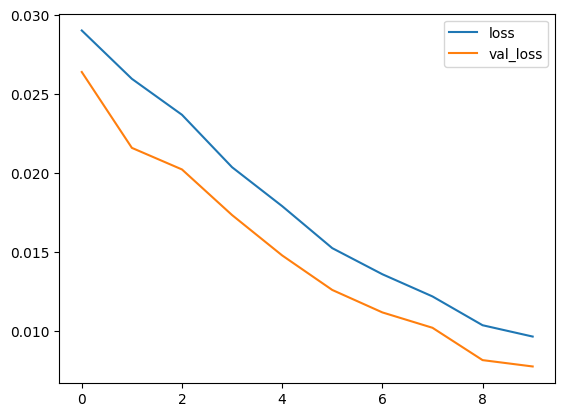

In [71]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

3. Make Predictions

In [60]:
input_text = vectorizer('nude')

In [61]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 437ms/step


In [62]:
res>0.5

array([[False, False, False, False, False, False]])

4. Evaluate Model

In [72]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [73]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [74]:
for batch in test.as_numpy_iterator():
    X_true, y_true=batch
    
    yhat = model.predict(X_true)

    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true,yhat)
    re.update_state(y_true,yhat)
    acc.update_state(y_true,yhat)

1/1 [==============================] - 0s 65ms/step


In [75]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9664060473442078, Recall: 0.9534285664558411, Accuracy: 0.38955822587013245


5. Gradio

In [78]:
!pip install gradio

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/50.9 kB ? eta -:--:--
     ---------------------------------------- 0.0/50.9 kB ? eta -:--:--
     ---------------- ----------------------- 20.5/50.9 kB ? eta -:--:--
     ------------------------------ ------- 41.0/50.9 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 50.9/50.9 kB 521.2 kB/s eta 0:00:00
     ---------------------------------------- 0.0/107.3 kB ? eta -:--:--
     ---------------------------------------- 0.0/107.3 kB ? eta -:--:--
     -------------- ---------------------- 41.0/107.3 kB 991.0 kB/s eta 0:00:01
     ----------------- ------------------- 51.2/107.3 kB 660.6 kB/s eta 0:00:01
     ------------------------ ------------ 71.7/107.3 kB 660.6 kB/s eta 0:00:01
     ---------------------------------- - 102.4/107.3 kB 590.8 kB/s eta 0:00:01
     ------------------------------------ 107.3/107.3 k

In [79]:
import gradio as gr

c:\Users\pc\anaconda3\envs\Toxicity10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [80]:
model.save('toxicity.h5')

In [82]:
model = tf.keras.models.load_model('toxicity.h5')

In [83]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text=''
    for idx, col in enumerate(df.columns[2:]):
        text +='{}:{}\n'.format(col,results[0][idx]>0.5)
    
    return text

In [89]:
interface = gr.Interface(fn=score_comment,
                         inputs = gr.inputs.Textbox(lines=2,placeholder='Comment to score'),
                         outputs='text')

In [ ]:
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder="Comment to score"),  # Use Textbox for input
    outputs="text"  # Output type remains "text"
)


In [90]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://b922e019f03c2d8f15.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 132ms/step
